### Conformalised Quantile Regression

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMRegressor

In [ ]:
def mu(x, a, b):
    return a + b*x

def het_sample(n, a, b):
    x = np.random.uniform(-8, 8, n)
    y = mu(x, a, b) + (np.abs(x) + 0.5) * np.random.randn(n)
    return np.column_stack((x, y))

In [45]:
n_train = 1000
n_cal = 3000
n_test = 2000
n = n_train + n_cal + n_test
alpha = 0.1

a, b, sigma = 1, -1, 3
D = het_sample(n, a, b)

D_train = D[:n_train,:]
D_cal = D[n_train:(n_train + n_cal),:]
D_test = D[(n_train + n_cal):(n_train + n_cal + n_test),:]

X_train = D_train[:, 0]
Y_train = D_train[:, 1]
X_cal = D_cal[:, 0]
Y_cal = D_cal[:, 1]
X_test = D_test[:, 0]
Y_test = D_test[:, 1]

In [15]:
model = LinearRegression()
model.fit(X_train.reshape(-1, 1), Y_train.reshape(-1, 1))

def absolute_residual(x, y, model):
    return np.abs(y - model.predict(x))

abs_errors = absolute_residual(X_train.reshape(-1, 1), Y_train.reshape(-1,1), model)

In [ ]:
lower_Q_regressor = LGBMRegressor(objective="quantile", alpha=alpha/2)
upper_Q_regressor = LGBMRegressor(objective="quantile", alpha= 1 - alpha/2)

lower_Q_regressor.fit(X_train.reshape(-1, 1), Y_train.reshape(-1, 1))
upper_Q_regressor.fit(X_train.reshape(-1, 1), Y_train.reshape(-1, 1))

def quantile_score(x, y, lower_q_model, upper_q_model):
    l = lower_q_model.predict(x) - y
    u = y - upper_q_model.predict(x)
    return np.maximum(l, u)

c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\lightgbm\basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\validation

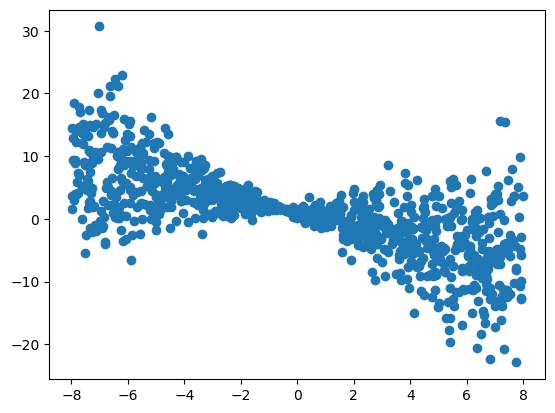

In [46]:
plt.scatter(X_train, Y_train)
#plt.scatter(X_train, upper_Q_regressor.predict(X_train.reshape(-1,1)), color="red")

c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\lightgbm\basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\lightgbm\basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(
c:\Users\shrey\anaconda3\envs\ml_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed

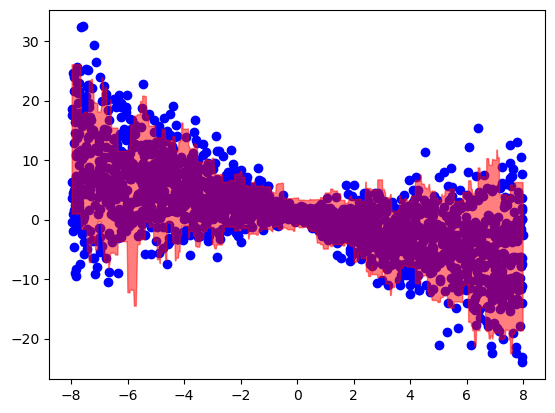

In [33]:
quantile_scores = quantile_score(X_cal.reshape(-1, 1), Y_cal, lower_Q_regressor, upper_Q_regressor)

q_cal = int(np.ceil((1-alpha)*(n_cal + 1)))
q_quantile = np.sort(quantile_scores.flatten())[q_cal - 1]

Y_lower_pred = lower_Q_regressor.predict(X_test.reshape(-1, 1))
Y_upper_pred = upper_Q_regressor.predict(X_test.reshape(-1, 1))

# Y_lower_pred = lower_Q_regressor.predict(X_cal.reshape(-1, 1))
# Y_upper_pred = upper_Q_regressor.predict(X_cal.reshape(-1, 1))

y_lower = Y_lower_pred - q_quantile
y_upper = Y_upper_pred + q_quantile

plt.scatter(X_test, Y_test, color="blue")
plt.fill_between(X_test[np.argsort(X_test)], y_lower[np.argsort(X_test)], y_upper[np.argsort(X_test)], color="red", alpha = 0.5)

# plt.scatter(X_cal, Y_cal, color="blue")
# plt.fill_between(X_cal[np.argsort(X_cal)], y_lower[np.argsort(X_cal)], y_upper[np.argsort(X_cal)], color="red", alpha = 0.5)

In [40]:
def get_local_coverage(z, n, q_cal, q_threshold, X, y, y_lower_hat, y_upper_hat):
    if q_cal >= n+1:
        return 1
    else:
        local_cov = np.zeros(len(z)-1)
        for i in range(len(z) - 1):
            idx_local = np.where((X <= z[i+1]) & (X >= z[i]))[0]
            y_local = y[idx_local]
            y_lower_hat = y_lower[idx_local]
            y_upper_hat = y_upper[idx_local]


            check_lower = (y_local >= y_lower_hat - q_threshold)
            check_upper = (y_local <= y_upper_hat + q_threshold)


            local_cov[i] = np.mean(check_lower & check_upper)

    return local_cov

In [41]:
width = 0.2
num = int((16/width)+1)
z = np.linspace(-8, 8, num)

In [42]:
local_cov_Q = get_local_coverage(z, n_cal, q_cal, q_quantile, X_test, Y_test, Y_lower_pred, Y_upper_pred)

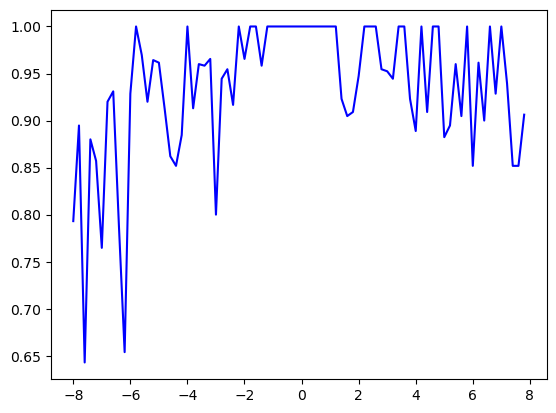

In [43]:
plt.plot(z[:-1], local_cov_Q, color="blue")